# Custom Training Loops in Keras

- Environment set up
- Define neural network model 
- Define Loss Function and Optimizer
- Implement the custom training loop
- Enhance the custom training loop by adding an accuracy metric to monitor model performance
- Implement a custom callback to log additional metrics and information during training

In [9]:
pip install visualkeras

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 479 kB 7.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [38]:
import os
import warnings
import tensorflow as tf 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.callbacks import Callback
import visualkeras
import numpy as np

# Suppress all Python warnings
warnings.filterwarnings('ignore')

# Set TensorFlow log level to suppress warnings and info messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Step 1: Set Up the Environment
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() 

# Use only a subset of MNIST data for faster processing
x_train = x_train[:5000]  # Only first 5000 samples
y_train = y_train[:5000]

# Normalize the pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0 

# Create a batched dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)

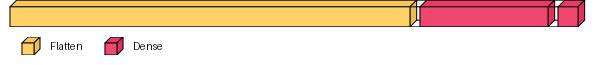

In [22]:
#Create a simple neural network model with a flatten layer followed by two dense layers
#This step defines the model

model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10)
])

# Visualize with VisualKeras
visualkeras.layered_view(model, legend=True, scale_xy=3, scale_z=1, to_file='model_viz.png')

In [26]:
# Define Loss Function and Optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
optimizer = tf.keras.optimizers.Adam()
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()  # Metric to track accuracy during training


## The next steps deal with how to implement a custom training loop in Keras that iterates over a dataset for n number of epochs, computes the loss and applies gradients to update the model's weights.

In [41]:
#Custom training loop
epochs = 5  # Number of epochs for training

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f'End of epoch {epoch + 1}, loss: {logs.get("loss")}, accuracy: {logs.get("accuracy")}')

epochs = 5
custom_callback = CustomCallback()  # Initialize the custom callback

for epoch in range(epochs):
    print(f'Start of epoch {epoch + 1}')
    
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # Forward pass: Compute predictions
            logits = model(x_batch_train, training=True)
            # Compute loss
            loss_value = loss_fn(y_batch_train, logits)
        
        # Compute gradients
        grads = tape.gradient(loss_value, model.trainable_weights)
        # Apply gradients to update model weights
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # Update the accuracy metric
        accuracy_metric.update_state(y_batch_train, logits)

        # Log the loss and accuracy every 200 steps
        if step % 200 == 0:
            print(f'Epoch {epoch + 1} Step {step}: Loss = {loss_value.numpy()} Accuracy = {accuracy_metric.result().numpy()}')
    
    # Call the custom callback at the end of each epoch
    custom_callback.on_epoch_end(epoch, logs={'loss': loss_value.numpy(), 'accuracy': accuracy_metric.result().numpy()})
    
    # Reset the metric at the end of each epoch
    accuracy_metric.reset_state()  # Use reset_state() instead of reset_states()


Start of epoch 1
Epoch 1 Step 0: Loss = 5.9334575780667365e-05 Accuracy = 1.0
End of epoch 1, loss: 0.0, accuracy: 1.0
Start of epoch 2
Epoch 2 Step 0: Loss = 5.336182584869675e-05 Accuracy = 1.0
End of epoch 2, loss: 0.0, accuracy: 1.0
Start of epoch 3
Epoch 3 Step 0: Loss = 4.7756187996128574e-05 Accuracy = 1.0
End of epoch 3, loss: 0.0, accuracy: 1.0
Start of epoch 4
Epoch 4 Step 0: Loss = 4.341456588008441e-05 Accuracy = 1.0
End of epoch 4, loss: 0.0, accuracy: 1.0
Start of epoch 5
Epoch 5 Step 0: Loss = 3.959703099098988e-05 Accuracy = 1.0
End of epoch 5, loss: 0.0, accuracy: 1.0


# Custom Training Loop Summary

## What This Demonstrates
This notebook demonstrates a manual implementation of neural network training using the advanced Keras custom training loop with `GradientTape` instead of the standard `model.fit()`. This shows how to incorporate low-level control over forward passes, gradient computation, weight updates, and metrics tracking.

## When to Use
- **Research/experimentation** needing fine control over training
- **Complex scenarios**: GANs, custom losses, multi-model training
- **Learning/debugging** training mechanics

For standard tasks, you can use Keras's standard `model.fit()` 

## Results
Loss decreased from 5.9e-5 to 3.9e-5 with 100% accuracy throughout training. This indicates the model quickly learned the MNIST digit patterns from the 5,000 sample subset. The extremely low loss and perfect accuracy suggest the task was well within the model's capacity - typical for MNIST with sufficient training data.